In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import MeanShift

matplotlib.style.use("seaborn")

# Loading data

## Checkins

In [2]:
checkins = pd.read_csv("./data/checkins.dat", delimiter='|', skiprows=[1], skipfooter=2, skipinitialspace = True, engine="python")
checkins.columns = checkins.columns.str.replace(' ', '')
checkins.replace(regex=r'^\s*$', value=np.nan, inplace=True)
checkins.dropna(inplace=True)

In [3]:
display(checkins)

,id,user_id,venue_id,latitude,longitude,created_at
1,984222,15824,5222,38.895112,-77.036366,2012-04-21 17:43:47
3,984234,44652,5222,33.800745,-84.410520,2012-04-21 17:43:43
7,984291,105054,5222,45.523452,-122.676207,2012-04-21 17:39:22
9,984318,2146539,5222,40.764462,-111.904565,2012-04-21 17:35:46
10,984232,93870,380645,33.448377,-112.074037,2012-04-21 17:38:18
...,...,...,...,...,...,...
1021959,955561,626076,20073,40.850100,-73.866246,2012-04-13 09:56:48
1021960,955892,674797,2297,33.748995,-84.387982,2012-04-13 10:56:03
1021961,956377,845102,11195,42.765366,-71.467566,2012-04-13 12:08:45
1021962,956119,1139114,29488,42.439479,-83.743830,2012-04-13 11:36:44


## Company coords

In [4]:
company_coords = pd.read_csv("./data/company_coords.csv")

In [5]:
display(company_coords)

,latitude,longitude,city
0,33.751277,-118.188740,Los Angeles
1,25.867736,-80.324116,Miami
2,51.503016,-0.075479,London
3,52.378894,4.885084,Amsterdam
4,39.366487,117.036146,Beijing
5,-33.868457,151.205134,Sydney


# Clustering

## Training

In [6]:
X = checkins[["latitude", "longitude"]].iloc[:100000, :]

In [7]:
%%time

ms = MeanShift(bandwidth=0.1)
ms.fit(X)

CPU times: user 2min 31s, sys: 438 ms, total: 2min 32s
Wall time: 2min 32s


MeanShift(bandwidth=0.1)

## Analyzing

In [8]:
print(f"Number of clusters: {len(set(ms.labels_))}")

Number of clusters: 3231


Number of clusters bigger 1500: 9


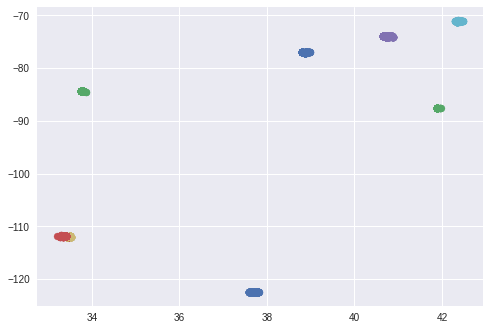

In [9]:
n = 1500
labels_of_big_clusters = [k for k, v in dict(Counter(ms.labels_)).items() if v > n]
print(f"Number of clusters bigger {n}: {len(labels_of_big_clusters)}")

for label in labels_of_big_clusters:
    plt.scatter(X[ms.labels_ == label]["latitude"], X[ms.labels_ == label]["longitude"])
plt.show()

## Finding most close ones

### extracting biggest cluster centers

In [10]:
n = 15
labels_of_big_clusters = [k for k, v in dict(Counter(ms.labels_)).items() if v > n]
print(f"Number of clusters bigger {n}: {len(labels_of_big_clusters)}")

cluster_centers = pd.DataFrame(ms.cluster_centers_[labels_of_big_clusters], columns=X.columns)
display(cluster_centers)

Number of clusters bigger 15: 592


,latitude,longitude
0,38.886165,-77.048783
1,33.766636,-84.393289
2,45.523483,-122.676280
3,40.759600,-111.896078
4,33.449438,-112.002140
...,...,...
587,-33.050462,-71.616452
588,-8.664363,115.211340
589,50.111512,8.680506
590,42.016667,-94.376667


### calculating distances to offices

In [11]:
distances = []

for cluster_center_index, cluster_center in cluster_centers.iterrows():
    for company_index, company in company_coords.iterrows():
        distances.append({
            "latitude": cluster_center["latitude"],
            "longitude": cluster_center["longitude"],
            "distance": np.linalg.norm(np.array([cluster_center["latitude"], cluster_center["longitude"]]) -  np.array([company["latitude"], company["longitude"]])),
            "city": company["city"]
        })
        
distances = pd.DataFrame(distances)
distances.sort_values(by="distance", inplace=True)
display(distances.iloc[:20])

,latitude,longitude,distance,city
839,-33.860630,151.204776,0.007835,Sydney
1623,52.372964,4.892317,0.009353,Amsterdam
2131,25.845672,-80.318891,0.022674,Miami
710,51.502991,-0.125537,0.050058,London
108,33.809878,-118.148924,0.070848,Los Angeles
991,25.785812,-80.217938,0.134109,Miami
841,25.705350,-80.283429,0.167406,Miami
673,26.010098,-80.199991,0.188876,Miami
1104,33.888325,-118.048928,0.195779,Los Angeles
558,33.872986,-118.362091,0.211811,Los Angeles


In [12]:
display(company_coords)

,latitude,longitude,city
0,33.751277,-118.188740,Los Angeles
1,25.867736,-80.324116,Miami
2,51.503016,-0.075479,London
3,52.378894,4.885084,Amsterdam
4,39.366487,117.036146,Beijing
5,-33.868457,151.205134,Sydney


# Writing answer

In [13]:
answer = distances.iloc[0]
with open("./output/ans.txt", "w") as f:
    f.write(f"{answer['latitude']} {answer['longitude']}")